/tmp/ipykernel_3361282/1286603033.py:122: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


Saved figures into 'viz_outputs' directory:
  - viz_outputs/cumulative.png
  - viz_outputs/first_char_bar.png
  - viz_outputs/length_histogram.png
  - viz_outputs/pie_top10.png
  - viz_outputs/top_bar_log.png
  - viz_outputs/top_horizontal.png
  - viz_outputs/zipf_loglog.png


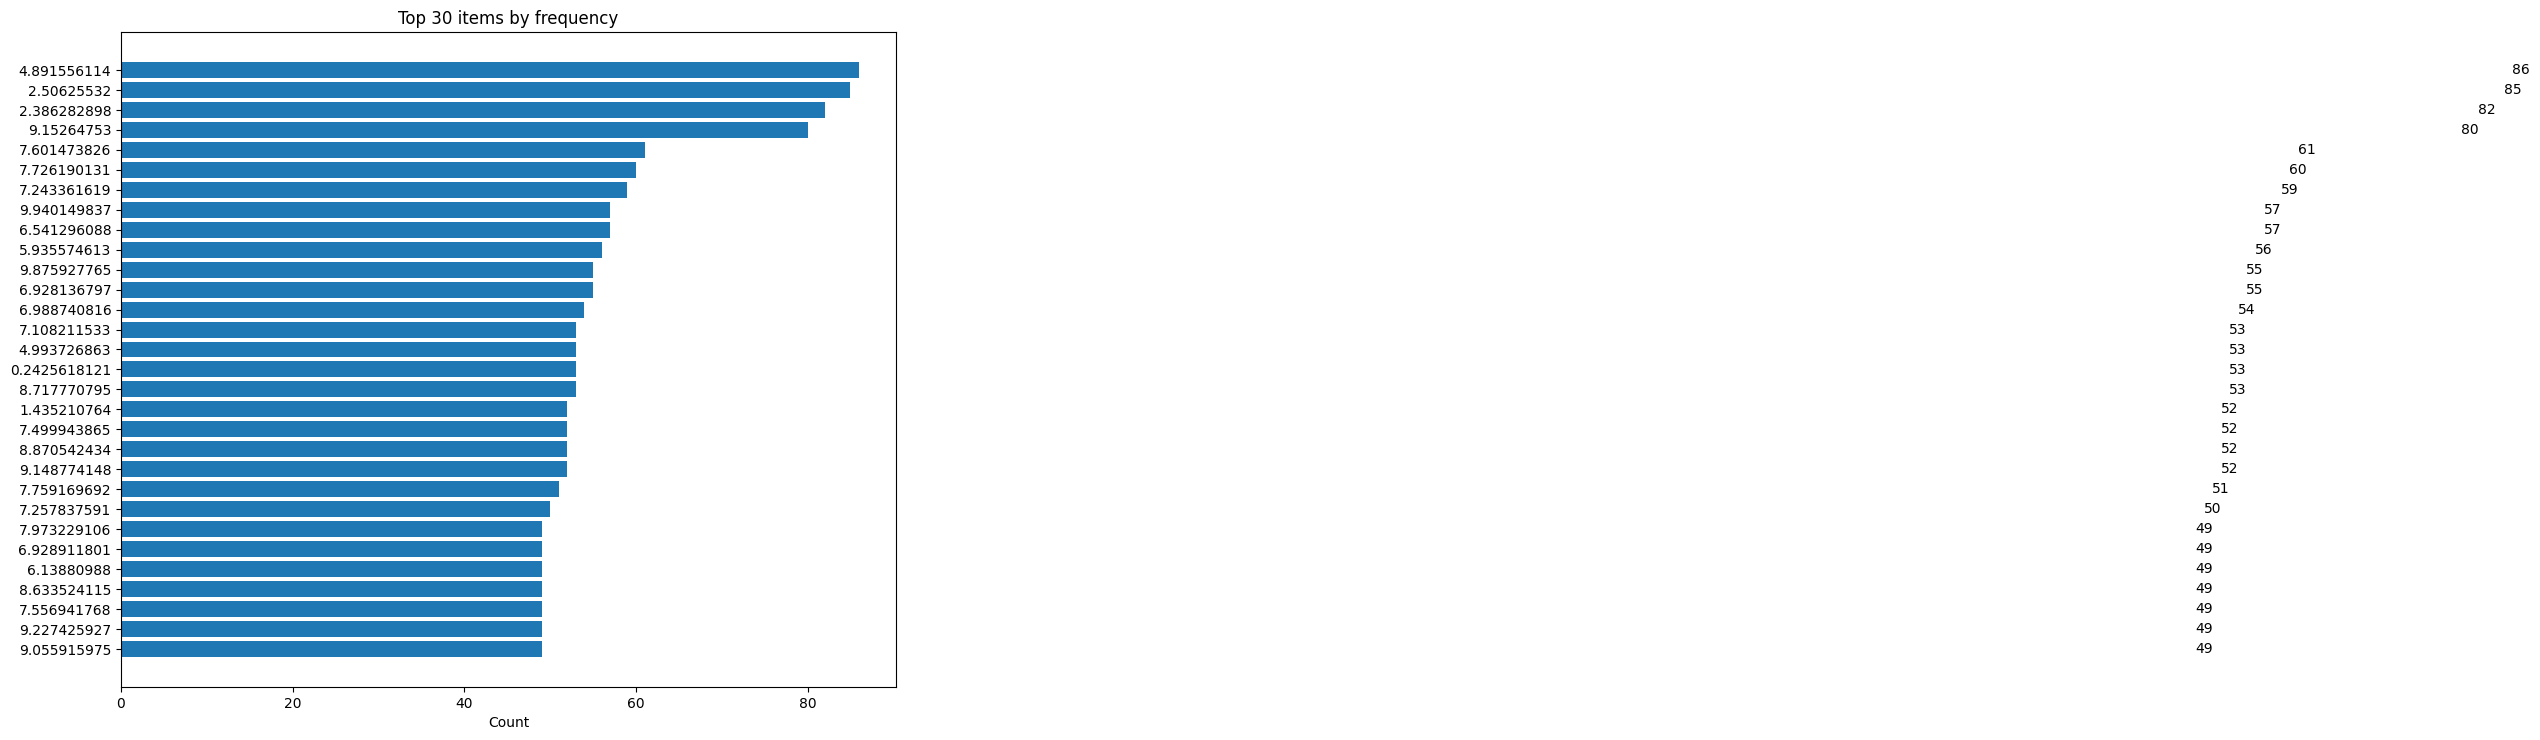

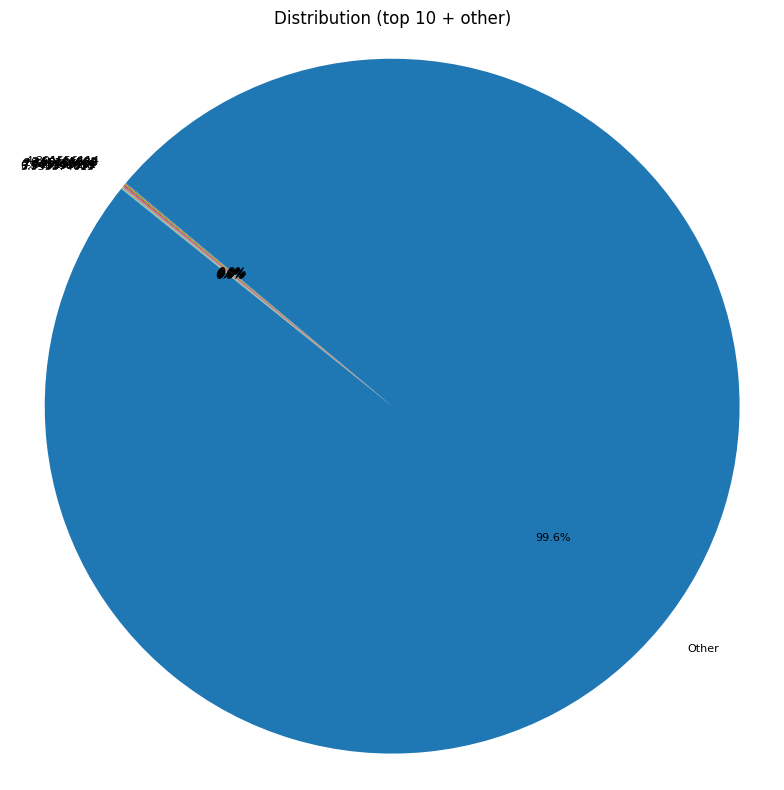

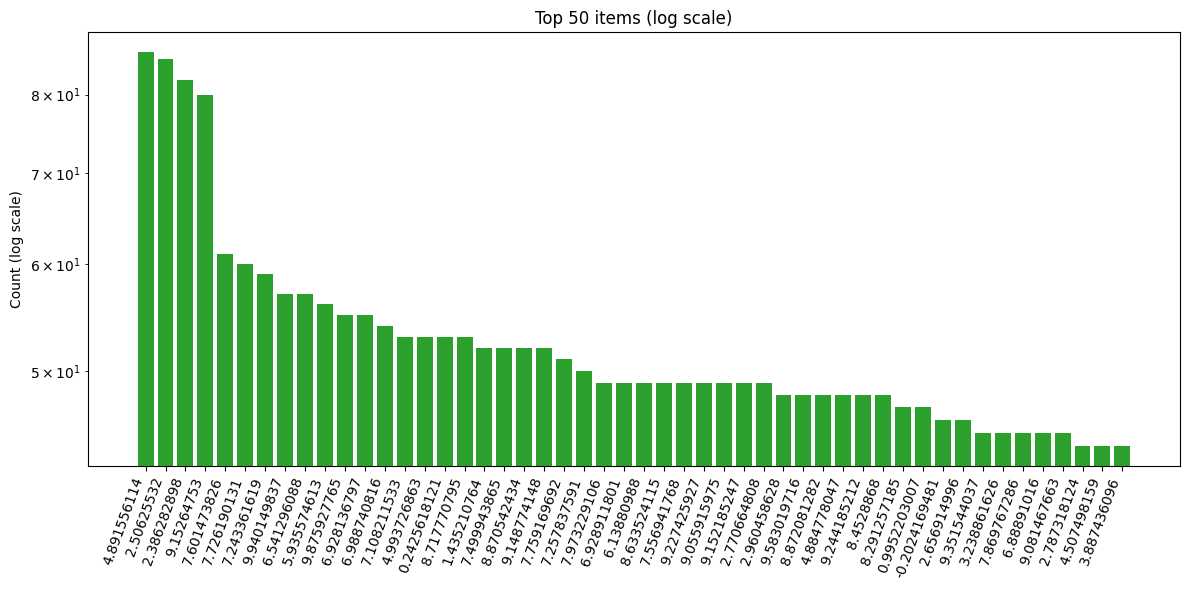

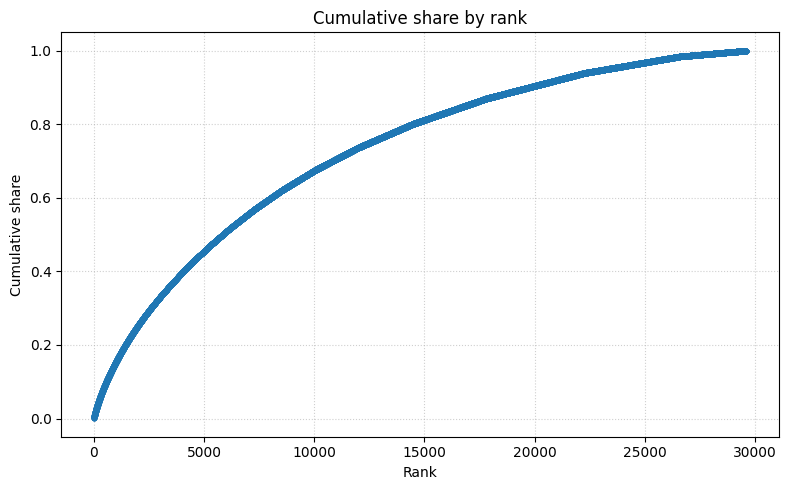

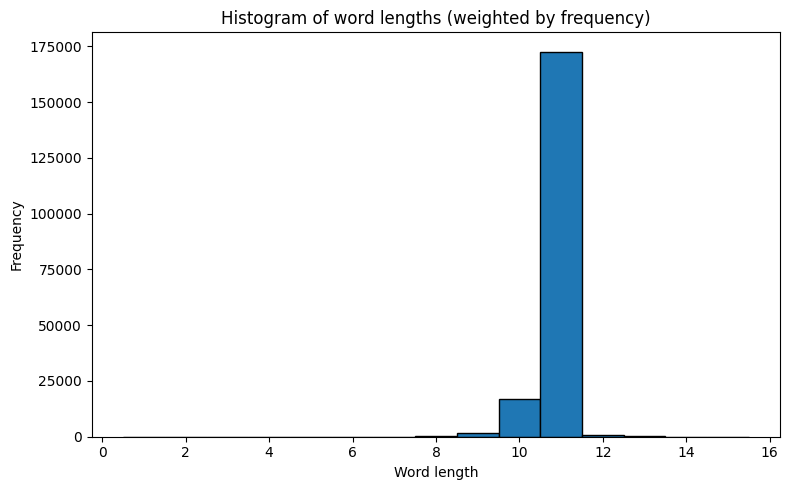

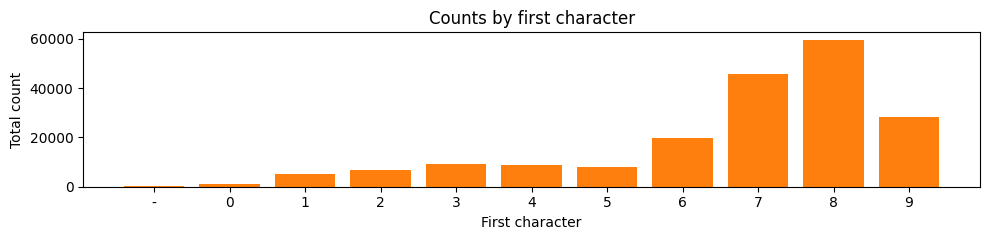

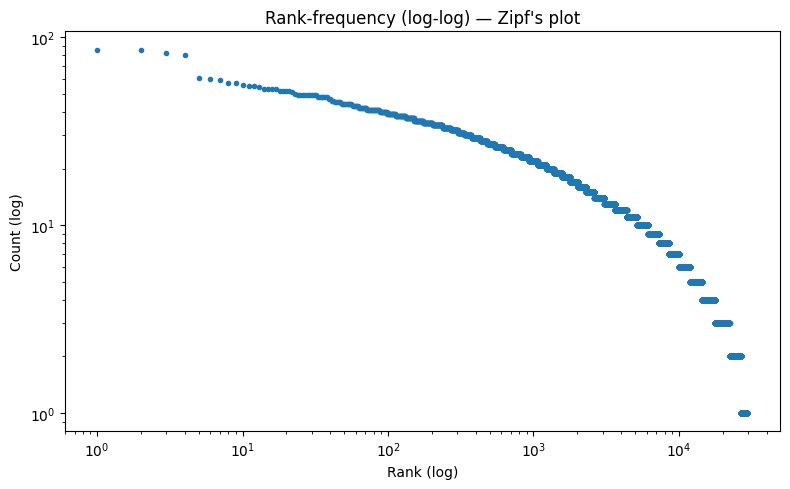

In [1]:
import os
import sys
from collections import Counter
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

def read_words_from_csv(path):
    try:
        df = pd.read_csv(path)
    except Exception:
        return None
    # Универсальные варианты:
    # 1) Есть столбцы 'word' и 'count' (или 'value')
    cols = [c.lower() for c in df.columns]
    if 'word' in cols and ('count' in cols or 'value' in cols):
        word_col = df.columns[cols.index('word')]
        cnt_col = df.columns[cols.index('count')] if 'count' in cols else df.columns[cols.index('value')]
        pairs = list(zip(df[word_col].astype(str).str.strip(), df[cnt_col].astype(float)))
        # Разворачиваем в повторяющийся список слов (поцелевому преобразованию)
        flat = []
        for w,c in pairs:
            if float(c).is_integer() and abs(int(c)) <= 10000:
                flat.extend([w]*int(c))
            else:
                flat.extend([w]*int(round(c)))
        return flat
    # 2) Есть столбец единственный со словами
    if df.shape[1] == 1:
        col = df.columns[0]
        
        words = []
        for cell in df[col].astype(str).fillna(''):
            cell = cell.strip()
            if not cell:
                continue
            words.extend(cell.split())
        return words
    # 3) Есть две колонки, возможно первая — индекс, вторая — value
    if df.shape[1] >= 2:
        # попробуем считать второй столбец как числа — если числа, возможно это counts
        a0 = df.iloc[:,0].astype(str).str.strip()
        a1 = df.iloc[:,1]
        if pd.api.types.is_numeric_dtype(a1):
            flat = []
            for w,c in zip(a0, a1):
                if not w: continue
                if float(c).is_integer() and abs(int(c)) <= 10000:
                    flat.extend([w]*int(c))
                else:
                    flat.extend([w]*int(round(c)))
            return flat
        else:
            # иначе объединяем все ячейки строк-wise
            words = []
            for row in df.itertuples(index=False):
                for cell in row:
                    if pd.isna(cell): continue
                    words.extend(str(cell).split())
            return words
    return None

def read_words_from_stdin():
    # читаем построчно до пустой строки или EOF, собираем слова
    words = []
    try:
        while True:
            line = sys.stdin.readline()
            if line == '':
                break
            line = line.rstrip('\n')
            if line == '':
                break
            words.extend(line.split())
    except Exception:
        pass
    return words

def load_words():
    csv_path = 'train_var_1.csv'
    words = None
    if os.path.exists(csv_path):
        words = read_words_from_csv(csv_path)
    if words is None or len(words) == 0:
        words = read_words_from_stdin()
    if words is None:
        words = []
    words = [str(w).strip() for w in words if str(w).strip() != '']
    return words

def prepare_counts(words):
    counter = Counter(words)
    # упорядочим по убыванию частоты
    items = counter.most_common()
    return counter, items

def plot_all(counter, items):
    os.makedirs('viz_outputs', exist_ok=True)

    # Подготовка данных
    labels = [it[0] for it in items]
    counts = np.array([it[1] for it in items], dtype=float)
    total = counts.sum()
    pct = counts / total * 100.0

    # 1) Горизонтальная столбчатая диаграмма топ-30
    top_n = min(30, len(items))
    fig, ax = plt.subplots(figsize=(10, max(4, top_n*0.25 + 1)))
    y = np.arange(top_n)
    ax.barh(y, counts[:top_n], color='tab:blue')
    ax.set_yticks(y)
    ax.set_yticklabels(labels[:top_n])
    ax.invert_yaxis()
    ax.set_xlabel('Count')
    ax.set_title(f'Top {top_n} items by frequency')
    for i, v in enumerate(counts[:top_n]):
        ax.text(v + max(0.01, total*0.001), i, str(int(v)), va='center')
    fig.tight_layout()
    fig.savefig('viz_outputs/top_horizontal.png', dpi=150)

    # 2) Круговая диаграмма для топ-10 (остальные — "Other")
    top_pie = min(10, len(items))
    pie_labels = labels[:top_pie] + (['Other'] if len(items) > top_pie else [])
    pie_counts = list(counts[:top_pie])
    if len(items) > top_pie:
        pie_counts.append(counts[top_pie:].sum())
    fig2, ax2 = plt.subplots(figsize=(8,8))
    wedges, texts, autotexts = ax2.pie(pie_counts, labels=pie_labels, autopct='%1.1f%%', startangle=140, textprops={'fontsize':8})
    ax2.axis('equal')
    ax2.set_title('Distribution (top 10 + other)')
    fig2.tight_layout()
    fig2.savefig('viz_outputs/pie_top10.png', dpi=150)

    # 3) Обычная столбчатая диаграмма top-50 (лог шкала)
    top_bar = min(50, len(items))
    fig3, ax3 = plt.subplots(figsize=(12,6))
    ax3.bar(range(top_bar), counts[:top_bar], color='tab:green')
    ax3.set_xticks(range(top_bar))
    ax3.set_xticklabels(labels[:top_bar], rotation=70, ha='right')
    ax3.set_yscale('log')
    ax3.set_ylabel('Count (log scale)')
    ax3.set_title(f'Top {top_bar} items (log scale)')
    fig3.tight_layout()
    fig3.savefig('viz_outputs/top_bar_log.png', dpi=150)

    # 4) Кумулятивная доля по ранжированным элементам (Лоренц-подобная кривая)
    fig4, ax4 = plt.subplots(figsize=(8,5))
    cum = np.cumsum(counts) / total
    x = np.arange(1, len(cum)+1)
    ax4.plot(x, cum, marker='o', markersize=3, linestyle='-')
    ax4.set_xlabel('Rank')
    ax4.set_ylabel('Cumulative share')
    ax4.set_title('Cumulative share by rank')
    ax4.grid(True, linestyle=':', alpha=0.6)
    fig4.tight_layout()
    fig4.savefig('viz_outputs/cumulative.png', dpi=150)

    # 5) Гистограмма длин слов (используем длину слова)
    lengths = [len(w) for w in labels for _ in range(1)] 
    expanded_lengths = []
    for w,c in items:
        expanded_lengths.extend([len(w)] * int(c))
    fig5, ax5 = plt.subplots(figsize=(8,5))
    ax5.hist(expanded_lengths, bins=range(1, max(expanded_lengths)+2), edgecolor='black', align='left')
    ax5.set_xlabel('Word length')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Histogram of word lengths (weighted by frequency)')
    fig5.tight_layout()
    fig5.savefig('viz_outputs/length_histogram.png', dpi=150)

    # 6) Heatmap-like: частоты первых букв (A-Z / others)
    firsts = {}
    for w,c in items:
        first = w[0].upper() if len(w) > 0 else ''
        firsts[first] = firsts.get(first, 0) + c
    # Сортируем по алфавиту ключей
    keys = sorted(firsts.keys())
    vals = [firsts[k] for k in keys]
    fig6, ax6 = plt.subplots(figsize=(10,2.5))
    ax6.bar(keys, vals, color='tab:orange')
    ax6.set_xlabel('First character')
    ax6.set_ylabel('Total count')
    ax6.set_title('Counts by first character')
    fig6.tight_layout()
    fig6.savefig('viz_outputs/first_char_bar.png', dpi=150)

    # 7) Столбчатая диаграмма частот (rank vs count) — лог-лог для проверки Zipf'а
    fig7, ax7 = plt.subplots(figsize=(8,5))
    ranks = np.arange(1, len(counts)+1)
    ax7.plot(ranks, counts, marker='.', linestyle='none')
    ax7.set_xscale('log')
    ax7.set_yscale('log')
    ax7.set_xlabel('Rank (log)')
    ax7.set_ylabel('Count (log)')
    ax7.set_title("Rank-frequency (log-log) — Zipf's plot")
    fig7.tight_layout()
    fig7.savefig('viz_outputs/zipf_loglog.png', dpi=150)

    print("Saved figures into 'viz_outputs' directory:")
    for fname in sorted(os.listdir('viz_outputs')):
        print("  -", os.path.join('viz_outputs', fname))

def main():
    words = load_words()
    if not words:
        print("No words found in input or 'train_var_1.csv' is empty.")
        return
    counter, items = prepare_counts(words)
    plot_all(counter, items)

if __name__ == '__main__':
    main()
